# Intent Classification with Keras
In my past notebooks, my goal was to recieve my labeled data for my chatbot. Now this notebook focuses on using Keras to classify intents of new, unseen data that a user might type up. The model now switched to a supervised learning approach now that we generated the labels from the unsupervised learning we did in the previous notebook.

In [15]:
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Deep Learning 
import tensorflow as tf
print(f"Tensorflow: {tf.__version__}")
from tensorflow import keras
print(f"Keras: {keras.__version__}")
import sklearn
print(f"Sklearn: {sklearn.__version__}")

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

import collections

Pandas: 1.0.5
Numpy: 1.18.5
Tensorflow: 2.2.0
Keras: 2.3.0-tf
Sklearn: 0.23.1


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Hold up...
One thing I am realizing from investigating other projects is that you cannot really force a clustering model to output the intents that you would like. It's an algorithm, after all... But instead of manually labelling the intents of the Twitter dataset (that is an absolute pain, doing it by hand for every 100 thousand Tweets!), it might be worth considering an entirely different approach, one where I have a smaller dataset that I manually label. In this alternative approach, I would give each intent a few examples - which is hopefully enough for my model to recognize that intent if it sees it in the future. This is the approach taken by cortical.io, they essentially need only not really that much data for recognizing an intent. Their approach is to create a semantic fingerprint for each intent cluster. It's so that when we embed new utterances, ones with similar meaning would have a closer distance. 

This is an approach that I think might work, because of (currently) the state of the art technologies and concepts such as self-attention  and transformer models utilizing specialized deep learning architectures.

I create this alternative data in a csv manually.

It also appealed to me that it's smarter to take my clusterings, then I personally subset the cluster intents myself to ensure that each cluster has some human intervention to determine that a clear overarching intent is represented nicely. You would notice that in this labeled data, there are many different ways to ask a express a certain intent, this is representative of how a real world person might ask a customer service bot a question, so that is definitely what I want! My data is preprocessed already in a way that it tries to keep just the essential tokens.

## EDA for Data I Work With

In [5]:
data = pd.read_csv('data/alternative_data.csv', encoding = "latin1", names = ["Sentence", "Intent"])

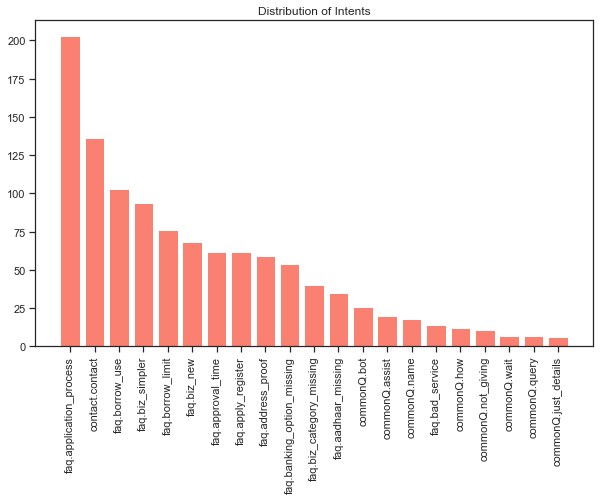

In [35]:
# Using counter from Collections to get the occurances of each Intent
c = collections.Counter(data['Intent'])
c = sorted(c.items())
counted = pd.DataFrame(c, columns = ['Unique Intent', 'Freq']).sort_values('Freq', ascending = False)

# Seeing the distribution of intents for seeing class imbalance
plt.figure(figsize=(10,6))
plt.bar(counted['Unique Intent'],counted['Freq'], color = 'salmon')
plt.title('Distribution of Intents')
plt.xticks(rotation=90)
plt.show()

# Exploration of Different Intent Classification Methods

There already exists chatbot frameworks people use, such as Wix.

Still, hopefully the intent classification of my Tweets would be good enough. The problem with my Tweets is that there are a lot of noise, and it's not clear what intent a particular Tweet represents. Also, I will definitely have class imbalance, in which I would have to do upsampling or down sampling to get my classification accuracies to be good.

I will create a neural network with Keras with the output layer having the same number of nodes as there are intents. I will use a softmax for this final layer to output a "confidence level" of the robot of being a certain intent.

### Question and Answering Example with Tensorflow
Found at [Hugging Face](https://huggingface.co/transformers/task_summary.html#sequence-classification)

Hugging face constantly updating with pretrained models.

Here is an example of question answering using a model and a tokenizer. The process is the following:

Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it with the weights stored in the checkpoint.
Define a text and a few questions.
Iterate over the questions and build a sequence from the text and the current question, with the correct model-specific separators token type ids and attention masks
Pass this sequence through the model. This outputs a range of scores across the entire sequence tokens (question and text), for both the start and end positions.
Compute the softmax of the result to get probabilities over the tokens
Fetch the tokens from the identified start and stop values, convert those tokens to a string.
Print the results

In [5]:
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = TFAutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""

questions = [
"How many pretrained models are available in 🤗 Transformers?",
"What does 🤗 Transformers provide?",
"🤗 Transformers provides interoperability between which frameworks?",]

for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="tf")
    input_ids = inputs["input_ids"].numpy()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer_start_scores, answer_end_scores = model(inputs)

    answer_start = tf.argmax(
    answer_start_scores, axis=1
    ).numpy()[0]  # Get the most likely beginning of answer with the argmax of the score
    answer_end = (
    tf.argmax(answer_end_scores, axis=1) + 1
    ).numpy()[0]  # Get the most likely end of answer with the argmax of the score
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    
    print(f"Question: {question}")
    print(f"Answer: {answer}")

TypeError: 'BertTokenizer' object is not callable

In [ ]:
# Question: How many pretrained models are available in 🤗 Transformers?
# Answer: over 32 +
# Question: What does 🤗 Transformers provide?
# Answer: general - purpose architectures
# Question: 🤗 Transformers provides interoperability between which frameworks?

### Keras Tokenizer

Creates a dictionary of all the words in the vocab, and it stores the index. For each sequence it passes in the sequence and converts each word into the index that refers to the Keras word dictionary. When you feed in sentences into the model, they all have to be the same length. But some tweets are going to be longer than others, so pad_sequences just pad all the other ones so they are on the same length. It padding the messages with 0s until they are the same length as the longest message. They might set a max-length that are shorter because longer sequences are harder to train on.

Got this tokenizer function from https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [109]:
# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0
# )

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

tokenized = tokenize(cleaned)

# Fitting my model
When I build my neural network with K fold cross validation, it will take a LONG time so you can probably get away without doing CV and hyperparamater optimization.